# Setting up the Data

Now that we've processed the data, we are ready to build our model. First off, let's create a class so that the data loader can load the data in batches. Once that's done, we can load the data, and start building the model. 

In [1]:
import datasets
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

In [2]:
# Loading the dataset from the laptop
dataset = datasets.load_from_disk("split_dataset/")

/opt/homebrew/anaconda3/envs/img_cls/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
# Displaying how the dataset looks like
dataset

DatasetDict({
    train: Dataset({
        features: ['images', 'labels'],
        num_rows: 2021
    })
    valid: Dataset({
        features: ['images', 'labels'],
        num_rows: 253
    })
    test: Dataset({
        features: ['images', 'labels'],
        num_rows: 253
    })
})

In [4]:
# Creating a class for the garbage dataset 
class GarbageDataset(torch.utils.data.Dataset): 
    def __init__(self, dataset, num_classes): 
        super().__init__() 
        self.dataset = dataset 
        self.dataset.set_format('pt') 
        self.num_classes = num_classes 
        
    def __len__(self):  
        return len(self.dataset) 

    def __getitem__(self, idx): 
        datapoint = self.dataset[idx] 
        image = datapoint['images'].type(torch.float)  
        image = image[:, ::8, ::8] # shrinking images by 8 because we tried using them in their original size and the model underperformed 
        label = torch.nn.functional.one_hot(datapoint['labels'], num_classes=self.num_classes) # dummy-coding the labels 
        label = label.type(torch.float) # converting labels into floats 
        return image, label 

In [5]:
# Creating instances of the class we created 
train_garbage_dataset = GarbageDataset(dataset=dataset['train'], num_classes=6)
valid_garbage_dataset = GarbageDataset(dataset=dataset['valid'], num_classes=6)
test_garbage_dataset = GarbageDataset(dataset=dataset['test'], num_classes=6)

In [6]:
# Checking the shape of the images
dataset['train'][0]['images'].shape

torch.Size([3, 384, 512])

In [7]:
# Checking the shape of the labels
train_garbage_dataset[1][0].shape

torch.Size([3, 48, 64])

In [8]:
# Importing the data loader to create batches of data
from torch.utils.data import DataLoader

In [9]:
# Creating instances of the DataLoader class
train_data_loader = DataLoader(dataset=train_garbage_dataset, batch_size=64, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_garbage_dataset, batch_size=64, shuffle=False)
test_data_loader = DataLoader(dataset=test_garbage_dataset, batch_size=64, shuffle=False) # no shuffling since the test set is not used in gradient descent 

In [10]:
# Getting one batch (of tensors) made of images and labels 
image_batch, label_batch = next(iter(train_data_loader)) 

In [11]:
# Checking the shape of the images
image_batch.shape 

torch.Size([64, 3, 48, 64])

In [12]:
# Checking the shape of the labels
label_batch.shape 

torch.Size([64, 6])

# Building the model

Now we're ready to build our model. 

In [13]:
from lightning import LightningModule

In [14]:
# Creating a class to build the model
class CNN(LightningModule):
    # Defining the layers of the model 
    def __init__(
        self, 
        input_channels, 
        hidden_channels,
        kernel_size,
        stride, 
        padding, 
        num_classes,
        x_dim,
        y_dim,
        learning_rate
    ):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=input_channels, 
            out_channels=hidden_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding 
        )
        self.relu1 = torch.nn.ReLU() 

        self.maxpooling1 = torch.nn.MaxPool2d(kernel_size=2) 

        self.conv2 = torch.nn.Conv2d(
            in_channels=hidden_channels,
            out_channels=2*hidden_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.relu2 = torch.nn.ReLU()

        self.maxpooling2 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv3 = torch.nn.Conv2d(
            in_channels=2*hidden_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.relu3 = torch.nn.ReLU()

        self.maxpooling3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.output = torch.nn.Linear(in_features=int(hidden_channels*x_dim*y_dim/4/4/4), out_features=num_classes) 

        self.loss = torch.nn.CrossEntropyLoss() 

        self.learning_rate = learning_rate

    # Applying all the model layers 
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.relu1(x) 
        x = self.maxpooling1(x) 
        x = self.conv2(x) 
        x = self.relu2(x) 
        x = self.maxpooling2(x) 
        x = self.conv3(x) 
        x = self.relu3(x) 
        x = self.maxpooling3(x) 
        x = x.view(x.size(0), -1) 
        out = self.output(x)
        return out 
        
    # Computing and returning the loss 
    def training_step(self, batch, batch_idx): 
        image_batch, label_batch = batch 
        output = self.forward(image_batch) 
        loss = self.loss(output, label_batch) 
        self.log('training_loss', loss) 
        return loss

    # Doing the same thing for the validation 
    def validation_step(self, batch, batch_idx): 
        image_batch, label_batch = batch 
        output = self.forward(image_batch) 
        loss = self.loss(output, label_batch) 
        self.log('validation_loss', loss) 
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [15]:
# Instantiating the model from the CNN class 
model = CNN(
    input_channels=3, 
    hidden_channels=64,
    kernel_size=5,
    stride=1, 
    padding=2, 
    num_classes=6,
    x_dim=48,
    y_dim=64,
    learning_rate=0.00001 # value of the learning rate with which we trained the best performing model so far 
)

# Training the model 

In [16]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

In [17]:
# Instantiating the model 
trainer = Trainer(
    max_epochs=100,
    callbacks=[ModelCheckpoint(save_top_k=1, monitor="validation_loss")]
) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
# Launching tensor board in the command line 
# tensorboard --logdir=~/Desktop/repos/garbage_classifier --port=6006

In [19]:
# Fitting the mdoel
trainer.fit(
    model,
    train_dataloaders=train_data_loader,
    val_dataloaders=valid_data_loader
)

Missing logger folder: /Users/giorgiadimiccoli/Desktop/repos/garbage_classifier/lightning_logs

   | Name        | Type             | Params
--------------------------------------------------
0  | conv1       | Conv2d           | 4.9 K 
1  | relu1       | ReLU             | 0     
2  | maxpooling1 | MaxPool2d        | 0     
3  | conv2       | Conv2d           | 204 K 
4  | relu2       | ReLU             | 0     
5  | maxpooling2 | MaxPool2d        | 0     
6  | conv3       | Conv2d           | 204 K 
7  | relu3       | ReLU             | 0     
8  | maxpooling3 | MaxPool2d        | 0     
9  | output      | Linear           | 18.4 K
10 | loss        | CrossEntropyLoss | 0     
--------------------------------------------------
433 K     Trainable params
0         Non-trainable params
433 K     Total params
1.732     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/img_cls/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/envs/img_cls/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/envs/img_cls/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [26]:
# Loading the best performing model 
ckpt = torch.load("lightning_logs/version_0/checkpoints/epoch=59-step=1920.ckpt")
model.load_state_dict(ckpt["state_dict"])
model.to("cpu")

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (maxpooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output): Linear(in_features=3072, out_features=6, bias=True)
  (loss): CrossEntropyLoss()
)

In [27]:
# Listing predictions and true values 
all_preds = []
all_true = []

# Iterating through each batch 
for img_batch, label_batch in test_data_loader:
    preds = model.forward(img_batch)
    all_preds.append(torch.argmax(preds, dim=-1)) # getting the index of the highest number among the preds 
    all_true.append(torch.argmax(label_batch, dim=-1)) 

# Concatenating the values and turning them into lists 
all_preds = torch.cat(all_preds).tolist()
all_true = torch.cat(all_true).tolist()

In [28]:
# Creating a dictionary of garbage labels and their digits 
classes_to_names_dict = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash",
}

# Computing the metrics of the model performance 
target_names = list(classes_to_names_dict.values())
print(classification_report(all_true, all_preds, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.74      0.69      0.71        51
       glass       0.46      0.54      0.50        46
       metal       0.62      0.51      0.56        47
       paper       0.71      0.79      0.75        56
     plastic       0.53      0.59      0.56        44
       trash       0.50      0.11      0.18         9

    accuracy                           0.61       253
   macro avg       0.59      0.54      0.54       253
weighted avg       0.62      0.61      0.61       253



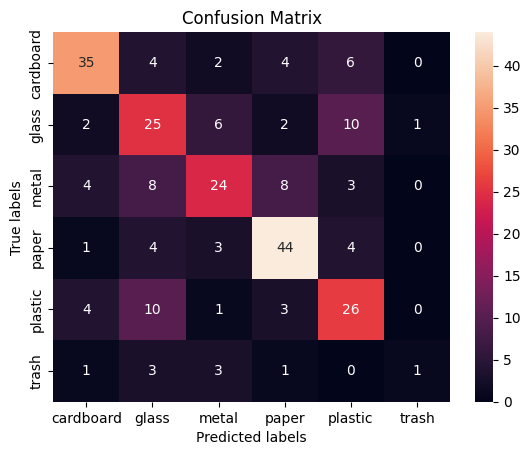

In [29]:
# Plotting a confusion matrix 
my_confusion_matrix = confusion_matrix(all_true, all_preds)

ax= plt.subplot()
sns.heatmap(my_confusion_matrix, annot=True, fmt='g', ax=ax);  

# Setting the labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

In [30]:
# Saving the model
torch.save(model, "train_garbage_model.pt")